In [1]:
import pandas as pd
import numpy as np
import glob, os, cv2
from matplotlib import pyplot as plt

In [41]:
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from keras import backend as K
from keras import regularizers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Input,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D,BatchNormalization,MaxPool2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D,AveragePooling2D,ReLU
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping,CSVLogger,ReduceLROnPlateau

2022-09-01 11:50:47.033868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rtrk/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-09-01 11:50:47.033885: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [36]:
RANDOM_STATE = 54
DIRECTORY = "UTKFace/"
NUM_OF_EPOCHES = 30
CLASSES_NAMES = [0,1,2,3,4,5,6,7,8]

In [6]:
# first number before _ in filenames of images are person's age (in 39_1_20170116174525125.jpg.chip.jpg 39 is the age)
# parsing and returning age for each image in directory
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age)
    except Exception as e:
        print(filepath)
        return None

In [7]:
files = glob.glob(os.path.join(DIRECTORY, "*.jpg"))
data = list(map(parse_filepath, files))

UTKFace/39_1_20170116174525125.jpg.chip.jpg
UTKFace/61_1_20170109150557335.jpg.chip.jpg
UTKFace/61_1_20170109142408075.jpg.chip.jpg


In [8]:
# making data frame with images and ages
df = pd.DataFrame(data)
df['file'] = files
df.columns = ['age', 'file']
df = df.sort_values(by=['age'])
df = df.dropna()
df.head()

,age,file
2158,1.0,UTKFace/1_1_2_20161219210955701.jpg.chip.jpg
20345,1.0,UTKFace/1_0_0_20161219200338012.jpg.chip.jpg
21263,1.0,UTKFace/1_1_0_20170109192728714.jpg.chip.jpg
16335,1.0,UTKFace/1_0_1_20170110213808936.jpg.chip.jpg
15811,1.0,UTKFace/1_0_3_20161219225723376.jpg.chip.jpg


In [9]:
df.shape

(23705, 2)

In [10]:
# grouping age in 9 intervals
def class_label(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 10:
        return 1
    elif 11 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 35:
        return 4
    elif 36 <= age <= 45:
        return 5
    elif 45 <= age <= 53:
        return 6
    elif 54 <= age <= 65:
        return 7
    else:
        return 8


In [11]:
df['target'] = df['age'].map(class_label)

In [12]:
# data is not balanced, so we are undersampling by taking 1600 random instances of the most numerous classes
class_3 = df[4878:10449].sample(frac=1)[:1600]
class_4 = df[10451:15107].sample(frac=1)[:1600]
class_5 = df[15108:18094].sample(frac=1)[:1600]
class_7 = df[19710:22006].sample(frac=1)[:1600]

In [13]:
# deleting all instances of the most numerous classes
df = df.drop(df[df['target']==3].index)
df = df.drop(df[df['target']==4].index)
df = df.drop(df[df['target']==5].index)
df = df.drop(df[df['target']==7].index)

In [14]:
# adding 1600 of each
df = pd.concat([df,class_3])
df = pd.concat([df,class_4])
df = pd.concat([df,class_5])
df = pd.concat([df,class_7])

In [15]:
df.shape

(14592, 3)

In [16]:
X_files = df['file']
y = df['target']
X = []

In [17]:
df.head()

,age,file,target
2158,1.0,UTKFace/1_1_2_20161219210955701.jpg.chip.jpg,0
20345,1.0,UTKFace/1_0_0_20161219200338012.jpg.chip.jpg,0
21263,1.0,UTKFace/1_1_0_20170109192728714.jpg.chip.jpg,0
16335,1.0,UTKFace/1_0_1_20170110213808936.jpg.chip.jpg,0
15811,1.0,UTKFace/1_0_3_20161219225723376.jpg.chip.jpg,0


In [18]:
for img in X_files:
    image = cv2.imread(img, cv2.IMREAD_COLOR)
    X.append(np.array(image))

In [19]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(y)
Y = to_categorical(Y,9)

In [20]:
X = np.array(X)
X = preprocess_input(X)

In [21]:
X.shape,Y.shape

((14592, 200, 200, 3), (14592, 9))

In [22]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.33, stratify=Y, random_state=RANDOM_STATE)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9776, 200, 200, 3), (4816, 200, 200, 3), (9776, 9), (4816, 9))

In [24]:
reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    restore_best_weights=False,
)

callbacks = [reduce, stop]

In [25]:
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

2022-09-01 11:51:05.655811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-01 11:51:05.656604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rtrk/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-09-01 11:51:05.656712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rtrk/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-09-01 11:51:05.656791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

58900480/58889256 [==============================] - 5s 0us/step


In [26]:
for layer in VGG16_model.layers:
    layer.trainable = False

x = VGG16_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output  = Dense(units=9, activation='softmax')(x)
model = Model(VGG16_model.input, output)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [27]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs = NUM_OF_EPOCHES,
                    verbose = 1,
                    validation_split=0.2,
                    callbacks=callbacks
                    )

Epoch 1/30


2022-09-01 11:51:11.374261: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3753600000 exceeds 10% of free system memory.


245/245 [==============================] - ETA: 0s - loss: 4.2757 - accuracy: 0.3107

2022-09-01 11:58:07.884731: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 938880000 exceeds 10% of free system memory.


245/245 [==============================] - 520s 2s/step - loss: 4.2757 - accuracy: 0.3107 - val_loss: 2.7990 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 2/30
245/245 [==============================] - 523s 2s/step - loss: 2.4639 - accuracy: 0.3958 - val_loss: 2.0588 - val_accuracy: 0.4294 - lr: 0.0010
Epoch 3/30
245/245 [==============================] - 524s 2s/step - loss: 1.9827 - accuracy: 0.4176 - val_loss: 1.7689 - val_accuracy: 0.4417 - lr: 0.0010
Epoch 4/30
245/245 [==============================] - 522s 2s/step - loss: 1.7647 - accuracy: 0.4322 - val_loss: 1.6249 - val_accuracy: 0.4463 - lr: 0.0010
Epoch 5/30
245/245 [==============================] - 524s 2s/step - loss: 1.6703 - accuracy: 0.4292 - val_loss: 1.5499 - val_accuracy: 0.4596 - lr: 0.0010
Epoch 6/30
245/245 [==============================] - 523s 2s/step - loss: 1.6137 - accuracy: 0.4412 - val_loss: 1.5157 - val_accuracy: 0.4678 - lr: 0.0010
Epoch 7/30
245/245 [==============================] - 522s 2s/step - loss: 

In [31]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [39]:
def evaluate_model(model,x_test,y_test,classes_names,conf_matrix_name):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    
    print(conf_mat)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

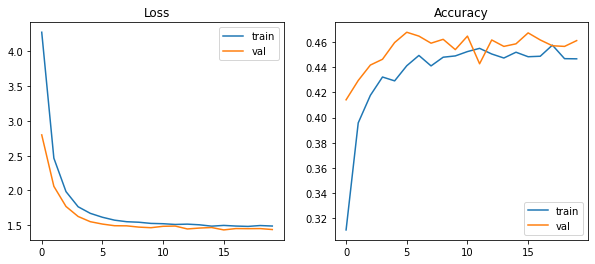

In [33]:
plot_acc_loss(history, 20)